Loaded sample with track_id: ['19316957-7db5-435d-b0e5-3c99332ee329']


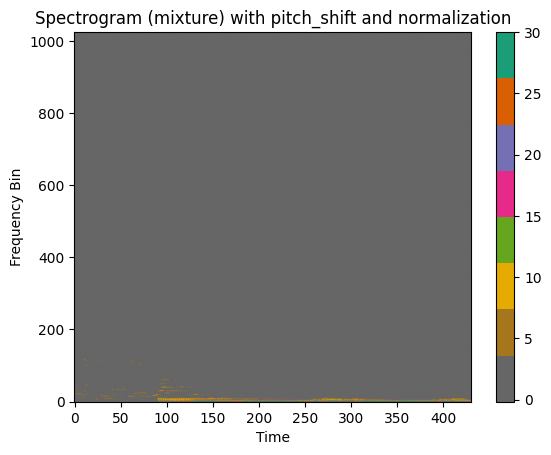

In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from process_musdb18 import AudioDatasetFolder, pitch_shift
import torch

# Define an additional simple normalization transform:
def normalize_spec(spec: torch.Tensor) -> torch.Tensor:
    return (spec - spec.mean()) / (spec.std() + 1e-6)

COMPONENT_MAP = ["mixture", "drums", "bass", "other_accompaniment", "vocals"]

IS_TRACK_ID = True
dataset_multi = AudioDatasetFolder(
    csv_file='output_stems/musdb18_index_20250408_121813.csv',
    audio_dir='.',  # adjust as needed
    components=COMPONENT_MAP,
    sample_rate=44100,
    duration=5.0,
    transform=[pitch_shift, normalize_spec],  # list of transforms
    is_track_id=IS_TRACK_ID,
)

loader_multi = DataLoader(dataset_multi, batch_size=1, shuffle=False)
sample_multi = next(iter(loader_multi))

if IS_TRACK_ID:
    print("Loaded sample with track_id:", sample_multi['track_id'])

# Plot spectrogram for the 'mixture' component.
spec_multi = sample_multi['mixture'][0, 0]  # select first sample and first channel
plt.imshow(spec_multi.detach().numpy(), origin='lower', aspect='auto', cmap='Dark2_r')
plt.title("Spectrogram (mixture) with pitch_shift and normalization")
plt.xlabel("Time")
plt.ylabel("Frequency Bin")
plt.colorbar()
plt.show()
